In [1]:
import numpy as np
from numpy.random import seed
seed(7)
import tensorflow as tf
from tensorflow.python.framework import ops
ops.reset_default_graph()
tf.random.set_seed(7)

import os
import glob
import pickle as pkl
import datetime

import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, cross_validate, cross_val_predict

from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

from hyperopt import Trials, fmin, tpe, hp, STATUS_OK

from pylab import rcParams
rcParams['figure.figsize'] = 10, 12

Custom model implementations and functions are stored in `src/dairyml.py`

In [2]:
from dairyml import *

## Import the Data
Load the data from the pickle files created in `preproccess.ipynb`

In [3]:
with open("../pkl/data/data_outliers_removed", "rb" ) as f:
    [X, Y] = pkl.load(f)

In [4]:
Y_reshaped = Y.values.reshape(-1,1)

## Modelling with Feed-Forward Neural Network (FFNN)

The below object splits the data into 5 folds, with shuffling. Random state is fixed for repeatability. I use 5 folds rather than 10 to save time running trials for hyperoptimization, 10 folds is used later for evaluation of the final model.

In [5]:
from splitting import *

#### define r^2 metric for keras model
Keras does not include an R^2 metric, so it is necessary to define it as done below

In [6]:
def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

### Function to build model

This function constructs a neural network with the specified parameters

In [7]:
def create_model(hidden_layers,num_nodes,alpha=0.01,lr=.001): 
    tf.random.set_seed(7)
    
    reg = regularizers.l2(alpha)
    
    model = Sequential()
    
    model.add(Dense(num_nodes, input_dim=X.shape[1], activation='relu', kernel_regularizer = reg))
    
    for i in range(0,hidden_layers-1):
        model.add(Dense(num_nodes, activation='relu', kernel_regularizer = reg))
        
    model.add(Dense(1, activation='linear'))
    
    adam = optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

    model.compile(loss='mean_squared_error', optimizer=adam,metrics=['mean_absolute_error'])
    return model

### Choose scoring measures for cross-validation

In [8]:
from scoring import *

Import results dataframe from CSV to store the testing results, create it if it doesn't exist

In [9]:
try:
    overall_results = pd.read_csv('../reports/cv_results.csv',index_col=0)
except FileNotFoundError:
    overall_results = pd.DataFrame(columns = scoring.keys())

### Define objective function for hyperparameter optimization

Hyperopt attempts to minimize an objective function. Since higher R^2 is better, we use 1-R^2 as our objective function (aka loss) to be minimized. 

This objective function takes in parameters, constructs a neural network and trains it according to the parameters, then evaluates the loss and returns it along with other results. All of this corresponds to one "trial" of hyperparameter optimization. The optimizer will conduct a number of trials with different parameters, and report the results associated with each set of parameters.

In [10]:
# EPOCHS = 2000
# X_shuf, Y_shuf = shuffle(X,Y,random_state=7)

def objective(params):
    hidden_layers = int(params['hidden_layers'])
    num_nodes = int(params['num_nodes'])
    alpha = params['alpha']
    lr = params['lr']
    epochs = int(params['epochs'])
    
    # Print configuration
    print('hidden_layers: {}'.format(hidden_layers))
    print('num_nodes: {}'.format(num_nodes))
    print('alpha: {}'.format(alpha))
    print('lr: {}'.format(lr))
    print('epochs: {}'.format(epochs))
    
    # build keras model with given configuration
    model = KerasRegressor(build_fn=create_model,
                           hidden_layers=hidden_layers,
                           num_nodes=num_nodes,
                           alpha=alpha,
                           lr=lr,
                           epochs=epochs, 
                           verbose=0)

    results = cross_validate(model,X,Y,cv=five_fold_no_repeat,scoring=scoring)

    # get average r2 from cv
    r2 = np.mean(results['test_r2'])
    
    # convert r2 to a loss
    loss = 1 - r2
    
    # print r2 result
    print('R^2: {}'.format(r2))
    print('\n')
    
    # return loss
    return {'loss': loss, 'params': params, 'r2': r2, 'cv_results': results, 'status': STATUS_OK}

### Define the hyperparameter search space

Each hyperparameter is given an initial probability distribution. This distribution represents our initial beliefs about where good hyperparameter values will be found within the search space. These probability distributions will be updated using Bayes' rule based on our results for each trial.

- **hidden layers:** uniform linear distribution between 1 and 2
- **nodes per layer:** uniform log between 3 and 100
- **learning rate**: uniform log between .0001 and .1
- **alpha** : uniform log between .0001 and .1
- **training epochs**:normal distribution, mean = 150, var = 25

In [11]:
space = {
            'hidden_layers': hp.quniform('hidden_layers', 1, 2, 1),
            'num_nodes': hp.qloguniform('num_nodes', np.log(3), np.log(100), 1),
            'lr': hp.loguniform('lr', np.log(1e-4), np.log(1e-1)),
            'alpha': hp.loguniform('alpha', np.log(1e-4), np.log(1e-1)),
            'epochs': hp.qnormal('epochs',150,25,5)
        }

### Define utility functions to save and load the trials object

In [12]:
def save_trials(trials):
    save_string = 'FFNN_trials-' + str(datetime.datetime.now().strftime("%Y-%m-%d %H-%M %p"))
    trials_dir = '../pkl/trials/FFNN/'
    
    try:
        os.makedirs(trials_dir)
    except FileExistsError:
        pass
    
    with open(trials_dir + save_string, "wb" ) as f:
        f.seek(0)
        pkl.dump(trials,f)
        
    print('saved to {}'.format(trials_dir + save_string))

def load_trials():
    trials_dir = "../pkl/trials/FFNN/*"
    list_of_files = glob.glob(trials_dir)
    latest_file = max(list_of_files, key=os.path.getctime)
    print('loading {}'.format(latest_file))
    
    with open(latest_file, "rb") as f:
        f.seek(0)
        trials = pkl.load(f)
        
    return trials

### Run hyperopt

The below function loads a trials object  (record of all previously conducted trials) from the disk, conducts one additional trial, adds the new results to the trials, and saves the updated trials object to disk. This allows the process of running trials to be stopped at any time without losing our results. 

In [13]:
def run_trials():

    trials_step = 1  # how many additional trials to do after loading saved trials. 1 = save after iteration
    max_trials = 3  # initial max_trials. put something small to not have to wait
    
    try:  # try to load an already saved trials object, and increase the max
        trials = load_trials()
        max_trials = len(trials.trials) + trials_step
        print("Rerunning from {} trials to {} (+{}) trials".format(len(trials.trials), max_trials, trials_step))
    except:  # create a new trials object and start searching
        trials = Trials()

    best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=max_trials, trials=trials)

    print("Best:", best)
    
    # save the trials object
    save_trials(trials)


Run trials indefinitely

In [14]:
# while True:
#     run_trials()

### Results

Load the most recent trials object

In [15]:
trials = load_trials()

loading ../pkl/trials/FFNN/FFNN_trials-2019-01-24 14-24 PM


Define a function to create a model based on parameters stored in the trials object

In [16]:
def create_from_params(params):
    tf.random.set_seed(7)
    hidden_layers = int(params['hidden_layers'])
    num_nodes = int(params['num_nodes'])
    alpha = params['alpha']
    lr = params['lr']
    epochs = int(params['epochs'])
    
    model = KerasRegressor(build_fn=create_model,
                       hidden_layers=hidden_layers,
                       num_nodes=num_nodes,
                       alpha=alpha,
                       lr=lr,
                       epochs=epochs, 
                       verbose=0)
    return model
    

Build a model using the best parameters from the trials object, evaluate using cross-validation

In [17]:
import json
submission_params = json.load(open('../models/ffnn_submission_params.json','r'))

In [18]:
# best = trials.best_trial['result']['params']

model=create_from_params(submission_params)

final_regressor_results = cross_validate(model,X,Y_reshaped,cv=ten_fold_no_repeat,scoring=scoring)

Report results

In [19]:
overall_results = scores_to_df(overall_results,'FFNN (Regressor Only)',final_regressor_results,refit='r2')

/Users/gabe/opt/miniconda3/envs/DairyML_old/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_r2'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/gabe/opt/miniconda3/envs/DairyML_old/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_SRC'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/gabe/opt/miniconda3/envs/DairyML_old/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_PCC'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwar

,cv_test_r2,cv_train_r2,cv_test_SRC,cv_train_SRC,cv_test_PCC,cv_train_PCC,cv_test_MI,cv_train_MI,cv_test_MAE,cv_train_MAE,cv_test_accuracy,cv_train_accuracy,cv_test_recall,cv_train_recall
Dummy Mean,-0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.01,1.94,1.93,NaN,NaN,NaN,NaN
Dummy Median All,-0.32,-0.29,0.00,0.00,0.00,0.00,0.00,0.00,1.68,1.68,NaN,NaN,NaN,NaN
Dummy Median Nonzero,-0.08,-0.06,0.00,0.00,0.00,0.00,0.00,0.00,1.77,1.77,NaN,NaN,NaN,NaN
"Perfect Clasif., Mean Regr.",0.13,0.13,0.73,0.73,0.41,0.40,0.49,0.52,1.53,1.53,NaN,NaN,NaN,NaN
Lasso,0.45,0.59,0.61,0.67,0.70,0.78,0.41,0.69,1.23,1.10,NaN,NaN,NaN,NaN
Bounded Lasso,0.55,0.66,0.64,0.69,0.75,0.82,0.43,0.65,1.08,0.97,NaN,NaN,NaN,NaN
Logistic Regression Classifier,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.89,1.0,0.95,1.0
Bounded Lasso + LogReg,0.64,0.74,0.80,0.89,0.82,0.87,0.61,0.87,0.86,0.74,NaN,NaN,NaN,NaN
Ridge,0.42,0.56,0.60,0.66,0.69,0.76,0.42,0.62,1.23,1.12,NaN,NaN,NaN,NaN
Bounded Ridge,0.53,0.65,0.63,0.70,0.74,0.82,0.45,0.68,1.10,0.97,NaN,NaN,NaN,NaN


Export results to CSV

In [20]:
overall_results.to_csv('../reports/cv_results.csv')

Plot actual vs predicted value of lactose content

In [21]:
y_pred = cross_val_predict(model,X,Y,cv=ten_fold_no_repeat)

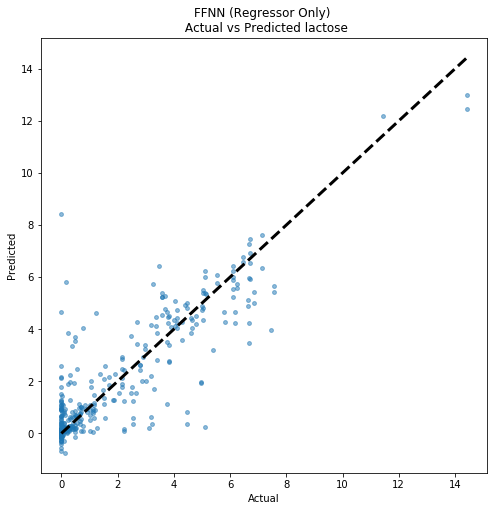

In [22]:
fig, ax = plt.subplots(figsize=[8,8])
ax.scatter(Y, y_pred, s=15, alpha=0.5)
ax.plot([Y.min(), Y.max()], [Y.min(), Y.max()], 'k--', lw=3)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title('FFNN (Regressor Only) \n Actual vs Predicted lactose')
plt.show()

### Fit to full dataset

In [23]:
model=create_from_params(submission_params)
model.fit(X,Y)

In [24]:
coefficients_FFNN = pd.DataFrame()
coefficients_FFNN['Feature'] = X.columns
coefficients_FFNN['FFNN first-layer weight'] = (np.mean(model.model.layers[0].get_weights()[0],axis=1))
coefficients_FFNN = coefficients_FFNN.set_index('Feature')
axs = coefficients_FFNN.sort_values('FFNN first-layer weight').plot.barh(y='FFNN first-layer weight')
# axs.set_title('FFNN Model First Layer Weights\n (Absolute Value)')
axs.set_title('FFNN Model First Layer Weights')
axs.set_xlabel('Weight')
axs.get_legend().remove()

In [25]:
coefficients_FFNN.to_csv('ffnn_coef.csv')

#### Save model to file

In [26]:
model.model.save("../models/ffnn.model")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ../models/ffnn.model/assets
